## Logistic Regression

In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [ ]:
df = pd.read_csv('titanic_disaster.csv')
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
df.nunique()

,0
PassengerId,891
Survived,2
Pclass,3
Name,891
Sex,2
Age,88
SibSp,7
Parch,7
Ticket,681
Fare,248


In [ ]:
df['Survived'].value_counts()

,count
Survived,
0,549
1,342


In [ ]:
irre_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_cleaned = df.drop(irre_cols, axis=1)

df_cleaned

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [ ]:
# Feature engineering for SibSp and Parch

df_cleaned['FamilySize'] = df_cleaned['SibSp'] + df_cleaned['Parch'] + 1
df_cleaned['IsAlone'] = (df_cleaned['FamilySize'] == 1).astype(int)

In [ ]:
df_cleaned = df_cleaned.drop(columns=['SibSp','Parch','Embarked','FamilySize'])
df_cleaned

,Survived,Pclass,Sex,Age,Fare,IsAlone
0,0,3,male,22.0,7.2500,0
1,1,1,female,38.0,71.2833,0
2,1,3,female,26.0,7.9250,1
3,1,1,female,35.0,53.1000,0
4,0,3,male,35.0,8.0500,1
...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,1
887,1,1,female,19.0,30.0000,1
888,0,3,female,NaN,23.4500,0
889,1,1,male,26.0,30.0000,1


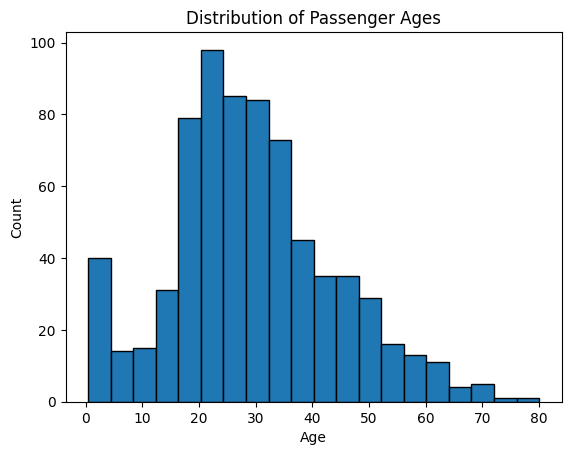

In [ ]:
# Checking for missing values
df_cleaned.isnull().sum()

# Checking the distribution of Age after removing NaN
age_data = df_cleaned['Age'].dropna()

# Plot histogram
plt.hist(age_data, bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Passenger Ages')
plt.show()

# It is right skewed so I'm gonna input the median

In [ ]:
# Imputing Missing Value for Age (Mean, Median, Most frequent)
numeric_col = ['Age']

imputer = SimpleImputer(strategy = 'median')
df_cleaned[numeric_col] = imputer.fit_transform(df_cleaned[numeric_col])

In [ ]:
#df['Fare'] = np.log1p(df['Fare'])

In [ ]:
# Imputing missing value for Embark (Mode/ Most frequent)
# cat_col = ['Embarked']

# imputer_cat = SimpleImputer(strategy = 'most_frequent')
# df_cleaned[cat_col] = imputer_cat.fit_transform(df_cleaned[cat_col])

In [ ]:
# Transforming categorical variables into dummy variables
# For logistic regression, it is suggested to convert Pclass to dummy, for decision trees is not needed (scale invariant)

#df_cleaned = pd.get_dummies(df_cleaned, columns=['Pclass', 'Sex'], drop_first=True, dtype=int)


In [ ]:
# One Hot Encoder

ohe = OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False)  # use sparse=True on older sklearn
cat_ohe = ohe.fit_transform(df_cleaned[["Pclass","Sex"]])

In [ ]:
# 1) OHE with readable names
ohe_cols = ohe.get_feature_names_out(["Pclass","Sex"])
cat_df = pd.DataFrame(cat_ohe, columns=ohe_cols, index=df_cleaned.index)

# 2) Scale numeric with explicit names
scaler = StandardScaler()
num_scaler = scaler.fit_transform(df_cleaned[['Age','Fare']])  # NOTE: fit on train in real use
num_df = pd.DataFrame(num_scaler, columns=['Age_z', 'Fare_z'], index=df_cleaned.index)

# 3) Reassemble (drop originals)
df_with_ohe = pd.concat(
    [df_cleaned.drop(columns=["Pclass","Sex","Age","Fare"]), cat_df, num_df],
    axis=1
)

df_with_ohe.head()


,Survived,IsAlone,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_z,Fare_z
0,0,0,0.0,0.0,1.0,0.0,1.0,-0.565736,-0.502445
1,1,0,1.0,0.0,0.0,1.0,0.0,0.663861,0.786845
2,1,1,0.0,0.0,1.0,1.0,0.0,-0.258337,-0.488854
3,1,0,1.0,0.0,0.0,1.0,0.0,0.433312,0.420730
4,0,1,0.0,0.0,1.0,0.0,1.0,0.433312,-0.486337


In [ ]:
# Scaling X

# scaler = StandardScaler()
# numeric_cols = ['Age','Fare']

# X_scaled = scaler.fit_transform(numeric_cols)
# #X_train_scaled = scaler.fit_transform(X_train)
# #X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
# Checking for multicollinearity or correlation
predictors = ['Age_z','Fare_z','IsAlone','Pclass_1','Pclass_2','Pclass_3','Sex_male','Sex_female']
corr = df_with_ohe[predictors].corr()
print(corr)

               Age_z    Fare_z   IsAlone  Pclass_1  Pclass_2  Pclass_3  \
Age_z       1.000000  0.096688  0.171647  0.323896  0.015831 -0.291955   
Fare_z      0.096688  1.000000 -0.271832  0.591711 -0.118557 -0.413333   
IsAlone     0.171647 -0.271832  1.000000 -0.113364 -0.039070  0.129472   
Pclass_1    0.323896  0.591711 -0.113364  1.000000 -0.288585 -0.626738   
Pclass_2    0.015831 -0.118557 -0.039070 -0.288585  1.000000 -0.565210   
Pclass_3   -0.291955 -0.413333  0.129472 -0.626738 -0.565210  1.000000   
Sex_male    0.081163 -0.182333  0.303646 -0.098013 -0.064746  0.137143   
Sex_female -0.081163  0.182333 -0.303646  0.098013  0.064746 -0.137143   

            Sex_male  Sex_female  
Age_z       0.081163   -0.081163  
Fare_z     -0.182333    0.182333  
IsAlone     0.303646   -0.303646  
Pclass_1   -0.098013    0.098013  
Pclass_2   -0.064746    0.064746  
Pclass_3    0.137143   -0.137143  
Sex_male    1.000000   -1.000000  
Sex_female -1.000000    1.000000  


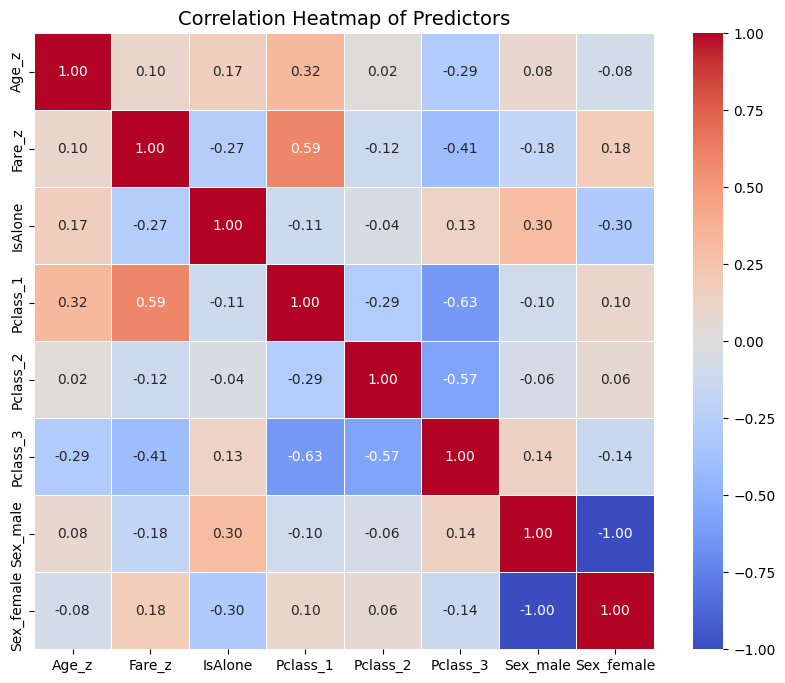

In [ ]:
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Predictors", fontsize=14)
plt.show()

In [ ]:
# Splitting the dataset, I removed IsAlone here because there is -0.69 correlation.
# Removing this feature decreased a bit of accuracy
predictors = ['Age_z','Fare_z','Pclass_1','Pclass_2','Pclass_3','Sex_male','Sex_female','IsAlone']

X = df_with_ohe[predictors]
y = df_with_ohe['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y , train_size = 0.75, random_state=42)


In [ ]:
# Fitting Logistic Regression to the model

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Getting the log odds of logistic
y_proba = lr.predict_proba(X_test)[:,1]

# Customizing threshold

threshold = 0.55
y_pred_thresh = (y_proba >= threshold).astype(int)

# Predict
#y_pred = lr.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_thresh)
print('Accuracy:', accuracy)

cm = confusion_matrix(y_test, y_pred_thresh)
print('Confusion Matrix:', cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh))

Accuracy: 0.7937219730941704
Confusion Matrix: [[115  19]
 [ 27  62]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       134
           1       0.77      0.70      0.73        89

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



In [ ]:
# Checking Coefficients and intercept
feature_names = X.columns

coef_table = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr.coef_[0]})

coef_table_sorted = coef_table.sort_values(by='Coefficient',ascending=False)
print(coef_table_sorted)

      Feature  Coefficient
6  Sex_female     1.267890
2    Pclass_1     0.827297
3    Pclass_2     0.219622
1      Fare_z     0.142660
7     IsAlone     0.098551
0       Age_z    -0.353374
4    Pclass_3    -1.032844
5    Sex_male    -1.253816


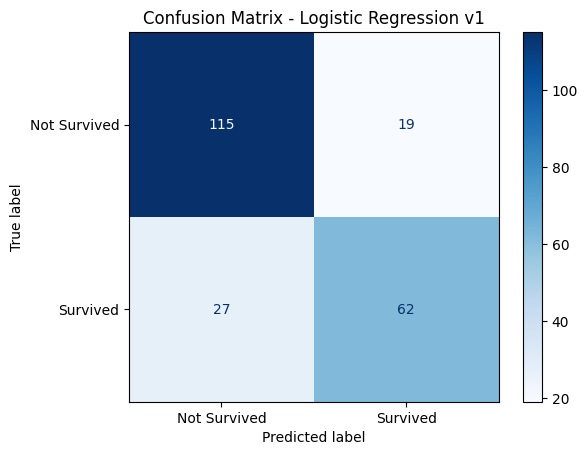

In [ ]:
# Confusion Matrix Display

disp = ConfusionMatrixDisplay(cm, display_labels=['Not Survived','Survived'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression v1')
plt.show()

# In this case we want to minimize False Positives (Predicting to be a survivor then dying is more painful)

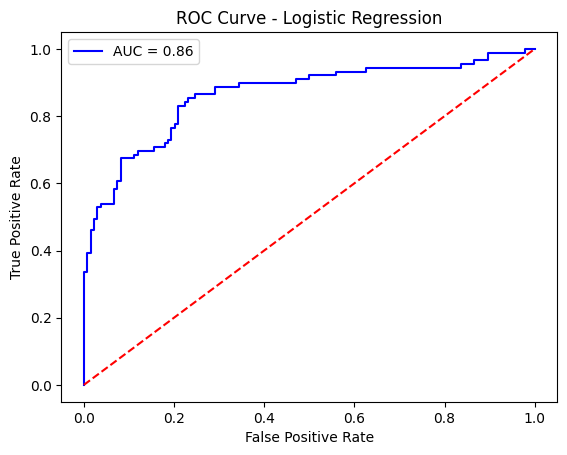

In [ ]:
# Improving the performance of logistic regression

y_proba = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc_score = roc_auc_score(y_test, y_proba)

# Plot ROC Curve
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()



In [ ]:
# Finding the best threshold (0.55 or 0.6)

thresholds = [0.5, 0.55, 0.6, 0.65, 0.70]

accuracies = []

for i in thresholds:
  y_pred_thresh = (y_proba >= i).astype(int)
  acc = accuracy_score(y_test, y_pred_thresh)
  print('Accuracy at a threshold',{i}, acc)

Accuracy at a threshold {0.5} 0.7892376681614349
Accuracy at a threshold {0.55} 0.7937219730941704
Accuracy at a threshold {0.6} 0.7982062780269058
Accuracy at a threshold {0.65} 0.7802690582959642
Accuracy at a threshold {0.7} 0.7937219730941704


In [ ]:
# # Define the model
# lr = LogisticRegression(max_iter=1000, random_state=42)

# # Define range of C values to test
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# # Use GridSearchCV to find the best one
# grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
# grid.fit(X_train_scaled, y_train)

# print("Best C:", grid.best_params_['C'])
# print("Best cross-validated accuracy:", grid.best_score_)


In [ ]:
# 1) Load data

train = pd.read_csv("titanic_disaster.csv")
test  = pd.read_csv("test.csv")

# Align names to your files; Kaggle Titanic commonly uses these:
Irre_cols_base  = ['PassengerId', 'Name', 'Ticket', 'Cabin']
Numeric    = ['Age', 'Fare']
Categorical= ['Pclass', 'Sex']


# 2) Features / target

target = "Survived"
X = train.drop(columns=[target])
y = train[target]


# Feature engineering for IsAlone

def add_IsAlone (df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()

  # In case of NAs in SibSp/Parch, treat missing as 0 for the family size logic
  sib = df.get('SibSp', 0).fillna(0)
  par = df.get('Parch', 0).fillna(0)
  df['FamilySize'] = sib + par + 1
  df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
  return df

fe = FunctionTransformer(add_IsAlone, validate=False)

# Removing the original columns used for feature engineering
irre_cols = Irre_cols_base + ['FamilySize', 'SibSp','Parch']

# 3) Preprocess & model pipeline

preprocess = ColumnTransformer(
    transformers=[
        ('drop_cols', 'drop', irre_cols),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), Numeric),
        ('cat', ohe, Categorical),
        ('alone', 'passthrough', ['IsAlone'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

pipeline = Pipeline([
    ('fe', fe),
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=500)) # Best to use the model here when you already fine tuned hyperparameters.
])

# 5) Fit on train

pipeline.fit(X, y)

# 6) Predict on test.csv

# If any required numeric column is entirely missing in test, imputer still handles NAs.
# Create predictions (class and probability)
test_pred = pipeline.predict(test)
test_prob = pipeline.predict_proba(test)[:, 1]

# Following Kaggle submission criteria
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_pred.astype(int)
})

# Getting probabilities too
submission_proba = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survival_Prob': test_prob
})

submission.to_csv("submission.csv", index=False)
submission_proba.to_csv("submission_prob.csv", index=False)


# # 7) Inspect transformed columns

feat_names = pipeline.named_steps['prep'].get_feature_names_out()

# For a peek at how test.csv was transformed:

X_test_trans = pipeline.named_steps['prep'].transform(
    pipeline.named_steps['fe'].transform(test))

X_test_trans_df = pd.DataFrame(X_test_trans, columns=feat_names)
print(X_test_trans_df.head())

        Age      Fare  Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  \
0  0.394887 -0.490783       0.0       0.0       1.0         0.0       1.0   
1  1.355510 -0.507479       0.0       0.0       1.0         1.0       0.0   
2  2.508257 -0.453367       0.0       1.0       0.0         0.0       1.0   
3 -0.181487 -0.474005       0.0       0.0       1.0         0.0       1.0   
4 -0.565736 -0.401017       0.0       0.0       1.0         1.0       0.0   

   IsAlone  
0      1.0  
1      0.0  
2      1.0  
3      1.0  
4      0.0  
